In [1]:
import numpy as np

from brodatz.data_utils import process_file, process_file_some_classes, read_some_classes, save_model, read_train_test_sets, save_history
from brodatz.utils import probas_to_classes, accuracy, curr_date
from brodatz.visualization_utils import plot_image, plot, plot_history, plot_confusion_matrix, plot_inputs

from brodatz.models.keras_neural_net import KerasNeuralNetwork

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from keras import regularizers, optimizers, utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# remove prefixes
import os
path = '/mnt/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/01_data_cls'
os.chdir(path)

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes_range)

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = read_some_classes('Alexander_cls_train.csv', classes_range)

In [ ]:
plot_image(X_mean)

In [ ]:
plot_image(X_train[10])

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = read_some_classes('Alexander_cls_train.csv', classes_range)
X_test, y_test, num_classes = read_some_classes('Alexander_cls_test.csv', classes_range)

X_train = X_train.astype('float') / 255
X_mean = np.mean(X_train, axis=0)
# X_std = np.std(X_train, axis=0)
# X_train = (X_train - X_mean) / (X_std + 1e-7)
X_train -= X_mean

X_test = X_test.astype('float') / 255
# X_test = (X_test - X_mean) / (X_std + 1e-7)
X_test -= X_mean
X_test = X_test[..., np.newaxis]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
X_train = X_train[..., np.newaxis]

mask = np.random.permutation(len(X_test))
# X_train = X_train[mask]
# y_train = y_train[mask]
num_train = round(len(X_test) * 0.8)
X_val = X_test[num_train:]
y_val = y_test[num_train:]
y_val = utils.to_categorical(y_val, num_classes=num_classes)

# num_train = round(len(X_train) * 0.8)
# X_val = X_train[num_train:]
# y_val = y_train[num_train:]
# X_train = X_train[:num_train]
# y_train = y_train[:num_train]

In [3]:
train_filename = 'Alexander_cls_train.csv'
test_filenames = ['Alexander_cls_test.csv',
                  'Alexander_cls_test1.csv',
                  'Alexander_cls_test2.csv',
                  'Alexander_cls_test3.csv',
                  'Alexander_cls_test4.csv']
classes_range = np.arange(0, 111)
X_train, y_train, num_classes, X_val, y_val, test_list = read_train_test_sets(train_filename, test_filenames, classes_range)

In [4]:
X_train.shape

(555, 200, 200, 1)

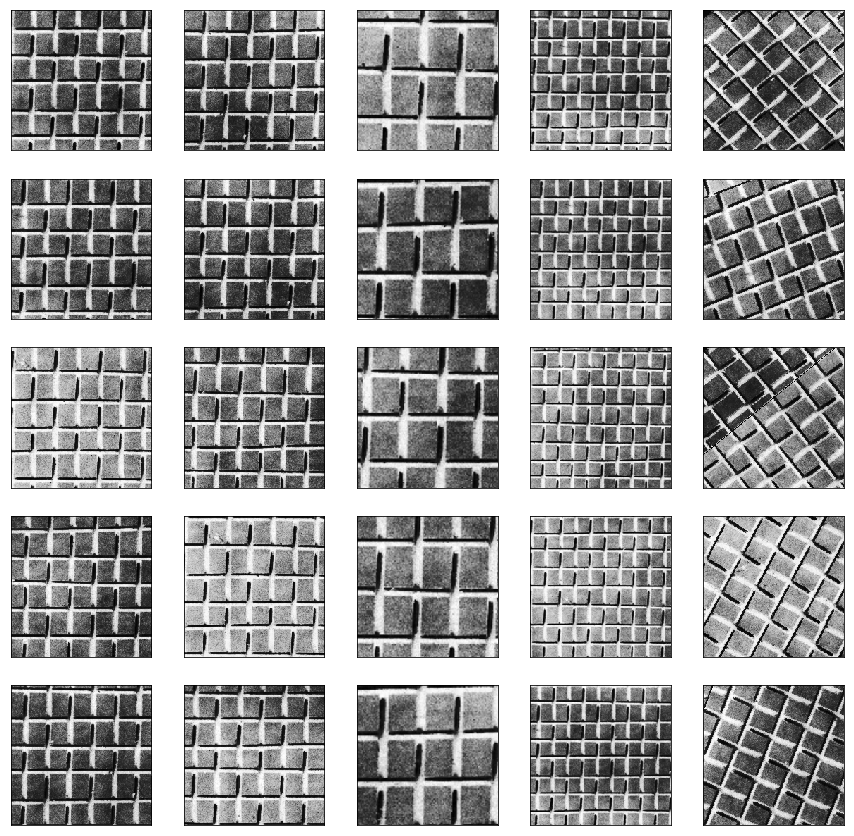

In [78]:
class_number = 0
mask = np.argmax(y_train, axis=1) == class_number
X_train_cls = X_train[mask]

test_list_cls = [test[0][np.argmax(test[1], axis=1) == class_number] for test in test_list]
test_list_cls = [X_train_cls] + test_list_cls[1:]

plot_inputs(test_list_cls)

In [ ]:
X_val, y_val = test_list[3][:2]

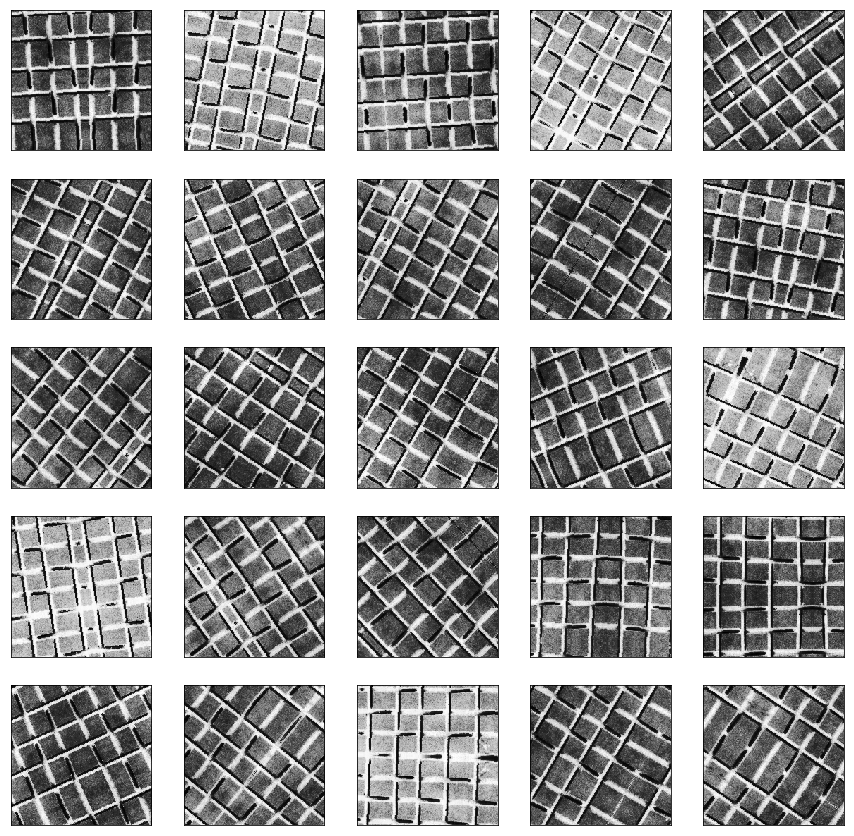

In [103]:
rotation_range = 180
shear_range = 0
# shear_range = 0
# shift_range = 0.4
shift_range = 0.5
# horizontal_flip = True
# vertical_flip = True
horizontal_flip = True
vertical_flip = True
zoom_range = 0
# zoom_range = [0.55, 0.65]
# zoom_range = [0.6, 0.7]
# zoom_range = [1.4, 1.5]
fill_mode = 'reflect'

datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    shear_range=np.pi * shear_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    zoom_range=zoom_range,
    fill_mode=fill_mode)

batch_list = []
i = 0
for batch in datagen.flow(X_train_cls, batch_size=5):
    batch_list.append(batch)
    i += 1
    if i % 5 == 0:
        break
    
plot_inputs(batch_list)

In [ ]:
batch_list[0].shape

In [ ]:
import json
import pandas as pd
import datetime

def try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode,
             batch_size, epochs, learning_rate, regularization_strength):
    input_shape = X_train[0].shape
    
    learning_rate = learning_rate
    regularizer = regularizers.l2(regularization_strength)
    optimizer = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
   
    net = KerasNeuralNetwork(input_shape, num_classes, regularizer=regularizer, optimizer=optimizer)
    net.compile_model_7()
    
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        shear_range=np.pi * shear_range,
        width_shift_range=shift_range,
        height_shift_range=shift_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        zoom_range=zoom_range,
        fill_mode=fill_mode)
    
    train_start = datetime.datetime.now()
    history = net.train(datagen, X_train, y_train, (X_val, y_val), epochs=epochs, batch_size=batch_size,)
    train_finish = datetime.datetime.now()
    train_duration = (train_finish - train_start).seconds
    
    model_name = curr_date() # name of the directory for model
    root_directory = '/home/stanislau/repository/machine-learning/brodatz/results/'
    directory_name = root_directory + curr_date()
    if not os.path.exists(directory_name):
        os.makedirs(directory_name) # create directory
        
    save_history(directory_name + '/loss.png', directory_name + '/accuracy.png', history) # save plots of loss and accuracy
        
    model_json = net.model.to_json()
    with open(directory_name + "/model.json", "w") as json_file:
        json_file.write(model_json) # save model to file
        
    utils.plot_model(net.model, to_file=directory_name + "/model.png", show_shapes=True) # save model png overview to file
    
    count_params = net.model.count_params() # number of model parameters
    optimizer_json = json.dumps(optimizers.serialize(optimizer))
    with open(directory_name + "/optimizer.json", "w") as json_file:
        json_file.write(optimizer_json) # save optimizer to file

    models_battles_filename = root_directory + 'models_battles.csv'
    header = ['Model name', 'X_train', 'X_test', 'X_test1', 'X_test2', 'X_test3', 'X_test4',
              'Epochs', 'Number of parameters', 'Batches', 'Learning rate', 'Train duration',
              'Rotation range', 'Shear range', 'Shift range', 'Hor flip', 'Ver flip', 'Zoom range', 'Fill mode',
              'Number of classes',
              'Regularization Strength']
    accuracies = [net.accuracy(X_test, y_test) for X_test, y_test, _ in [(X_train, y_train, num_classes)] + test_list]
    data = [model_name]
    data.extend(accuracies)
    number_of_params = net.model.count_params()
    data.extend([epochs, number_of_params, batch_size, learning_rate, train_duration])
    data.extend([rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode])
    data.append(num_classes)
    data.append(regularization_strength)
    if not os.path.isfile(models_battles_filename):
        df = pd.DataFrame([data], columns=header)
        df.to_csv(models_battles_filename)
    else:
        with open(models_battles_filename, 'a') as f:
            df = pd.DataFrame([data])
            df.to_csv(f, header=False)

rotation_ranges = [0, 45, 90, 135, 180]
shear_ranges = [0, 0.2, 0.25, 1/3, 0.5, 0.75, 1]
shift_ranges = [0, 0.15, 0.3, 0.4, 0.45]
horizontal_flips = [True, False]
vertical_flips = [True, False]
zoom_ranges = [0, 0.2, 0.35, 0.5, 0.7, [0.6, 0.7], [1.4, 1.5]]
fill_modes = ['reflect', 'nearest', 'wrap']
learning_rates = [0.001, 0.002, 0.005, 0.01]
regularization_strengths = [0.001, 0.01, 0.05, 0.1]

rotation_range = rotation_ranges[4]
shear_range = shear_ranges[3]
shift_range = shift_ranges[3]
horizontal_flip = horizontal_flips[0]
vertical_flip = vertical_flips[0]
zoom_range = zoom_ranges[6]
fill_mode = fill_modes[0]
batch_size = 64
epochs = 250
learning_rate = learning_rates[2]
regularization_strength = regularization_strengths[1]

try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode, batch_size, epochs, learning_rate, regularization_strength)

# for shear_range in shear_ranges:
#     try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode, batch_size, epochs)

In [ ]:
zoom_ranges = [0, 0.2, 0.35, 0.5, 0.7, [0.5, 1.0], [1.0, 1.5]]

In [ ]:
zoom_ranges[4:]

In [ ]:
input_shape = (200, 200, 1)

learning_rate = 0.01

regularizer = regularizers.l2(0.01)
optimizer = optimizers.SGD(lr=learning_rate, decay=1e-7, momentum=0.9, nesterov=True)
# optimizer = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

net = KerasNeuralNetwork(input_shape, num_classes, regularizer=regularizer, optimizer=optimizer)
net.compile_model_6()

In [ ]:
history = net.train(X_train, y_train, (X_val, y_val), epochs=100, batch_size=256, )

In [ ]:
plot_history(history)

In [ ]:
net.model.summary()

In [ ]:
model_name = curr_date()

In [ ]:
root_directory = '/home/stanislau/repository/machine-learning/brodatz/results/'
directory_name = root_directory + curr_date()

In [ ]:
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

In [ ]:
model_json = net.model.to_json()
with open(directory_name + "/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
utils.plot_model(net.model, to_file=directory_name + "/model.png", show_shapes=True)

In [ ]:
accuracies = [net.accuracy(X_test, y_test) for X_test, y_test, _ in [(X_train, y_train, num_classes)] + test_list]

In [ ]:
accuracies